#### Path manipulation to be able to import scripts inside the codes/ folder

In [1]:
import sys
from pathlib import Path
basepath = Path("../..")
sys.path.append(str(basepath))

#### Imports and configurations for plotting

In [2]:
from codes.plotting import configure_matplotlib_defaults
configure_matplotlib_defaults(fontsize = 13)
import matplotlib.pyplot as plt

#### Read nid file and store relevant data into variables

In [3]:
from codes.fileio import read_nid
file = basepath/"data/afm/20230106/highly entangled hydrogel(C=3.2)/Image00709.nid"
config, data = read_nid(file)
print(list(data.keys()))
print(list(config.sections()))

modes = ("forward", "backward")
z_sens = {mode: data[f"z-axis sensor_spec {mode}"].reshape(-1)*1.0e6 for mode in modes}
defl = {mode: data[f"deflection_spec {mode}"].reshape(-1)*1.0e6 for mode in modes}
z_tip = {mode: z_sens[mode] - defl[mode] for mode in modes}

['deflection_spec forward', 'z-axis sensor_spec forward', 'deflection_spec backward', 'z-axis sensor_spec backward', 'tip-sample separation_indentationzsensorfwd0', 'tip-sample separation_indentationzsensorbwd0', 'deflection_indentationdeflfwd0', 'deflection_indentationdeflbwd0', 'namez4_slopeout00', 'namez5_slopeout10', 'namez6_slopeout20', 'namez7_maxadhesionout00', 'namez8_maxadhesionout10', 'namez9_slopeout01', 'namez10_slopeout11', 'namez11_slopeout21', 'namez12_snapinout00', 'namez13_snapinout10', 'deflection_scan forward', 'z-axis_scan forward', 'z-axis sensor_scan forward', 'deflection_scan backward', 'z-axis_scan backward', 'z-axis sensor_scan backward']
['DataSet', 'DataSet-Info', 'DataSet\\DataSetInfos', 'DataSet\\DataSetInfos\\Spec', 'DataSet\\DataSetInfos\\Scan', 'DataSet\\DataSetInfos\\Feedback', 'DataSet\\DataSetInfos\\Module', 'DataSet\\DataSetInfos\\Global', 'DataSet\\Calibration', 'DataSet\\Calibration\\Scanhead', 'DataSet\\Calibration\\Cantilever', 'DataSet\\Paramete

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Tip position (um)')

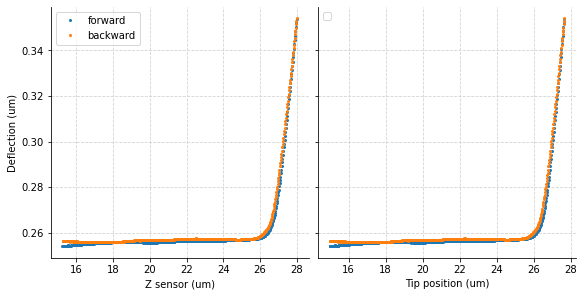

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, constrained_layout = True)
plot_kwargs = {"markersize": 4}
for mode in modes:
    axes[0].plot(
        z_sens[mode],
        defl[mode],
        ".",
        label=mode,
        **plot_kwargs
    )
    axes[1].plot(z_tip[mode], defl[mode], ".", **plot_kwargs)

for ax in axes:
    ax.legend()
    
axes[0].set_ylabel("Deflection (um)")
axes[0].set_xlabel("Z sensor (um)")
axes[1].set_xlabel("Tip position (um)")

#### Locate the knee point

Text(0.5, 0, 'Tip position (um)')

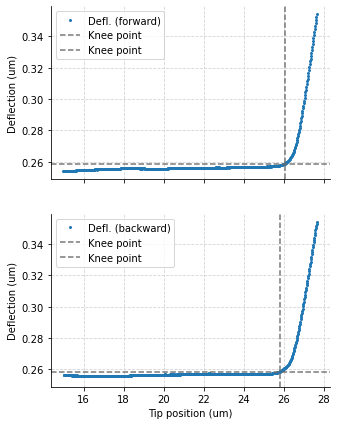

In [5]:
import kneed
knee_locs = {mode: kneed.KneeLocator(z_tip[mode], defl[mode], curve = "convex") for mode in modes}
fig, axes = plt.subplots(2, 1, figsize = (5, 7), sharex = True, sharey = True)
for mode, ax in zip(modes, axes):
    ax.plot(z_tip[mode], defl[mode], ".", label = f"Defl. ({mode})", **plot_kwargs)
    ax.axvline(x = knee_locs[mode].knee, color = "dimgray", linestyle = "--", alpha = 0.9, label = "Knee point")
    ax.axhline(y = knee_locs[mode].knee_y, color = "dimgray", linestyle = "--", alpha = 0.9, label = "Knee point")
    ax.set_ylabel("Deflection (um)")
    ax.legend()

axes[-1].set_xlabel("Tip position (um)")


In [12]:
import numpy as np
def offset_powerlaw(x: np.ndarray, a: float, b: float, x0: float, y0: float) -> np.ndarray:
    return y0+a*np.abs(x-x0)**b

from scipy.optimize import curve_fit

results = {}
for mode in modes:
    kneex, kneey = knee_locs[mode].knee, knee_locs[mode].knee_y
    selection = z_tip[mode]>kneex
    param_init_guess = (0.01, 2.0)
    lower_bounds = [0.0, 0.0]
    upper_bounds = [np.inf, np.inf]
    def power_law(x, a, b):
        return offset_powerlaw(x, a, b, kneex, kneey)
    results[mode] = curve_fit(power_law, z_tip[mode][selection], defl[mode][selection], p0 = param_init_guess, bounds = (lower_bounds, upper_bounds))
results

{'forward': (array([0.04097719, 1.83759349]),
  array([[ 4.54814516e-08, -2.53866489e-06],
         [-2.53866489e-06,  2.31256143e-04]])),
 'backward': (array([0.0298298 , 1.92541546]),
  array([[ 5.19655371e-08, -3.32670549e-06],
         [-3.32670549e-06,  2.60395067e-04]]))}

Text(0.5, 0, 'Tip position (m)')

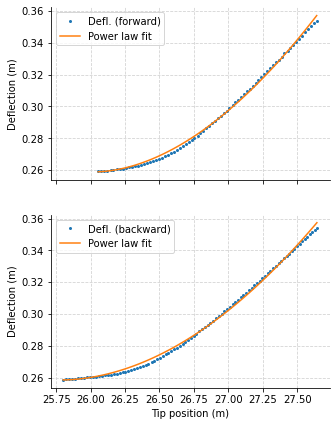

In [13]:
fig, axes = plt.subplots(2, 1, figsize = (5, 7), sharex = True, sharey = True)
for mode, ax in zip(modes, axes):
    kneex, kneey = knee_locs[mode].knee, knee_locs[mode].knee_y
    selection = z_tip[mode]>knee_locs[mode].knee
    ax.plot(z_tip[mode][selection], defl[mode][selection], ".", label = f"Defl. ({mode})", **plot_kwargs)
    ax.plot(z_tip[mode][selection], offset_powerlaw(z_tip[mode][selection], *results[mode][0], kneex, kneey), label = "Power law fit")
    ax.set_ylabel("Deflection (m)")
    ax.legend()

axes[-1].set_xlabel("Tip position (m)")

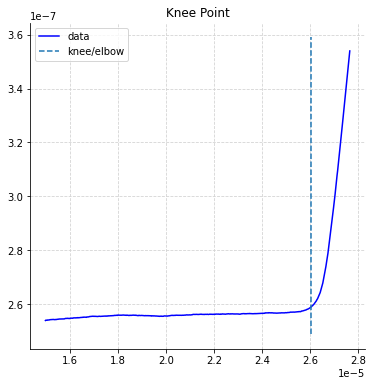

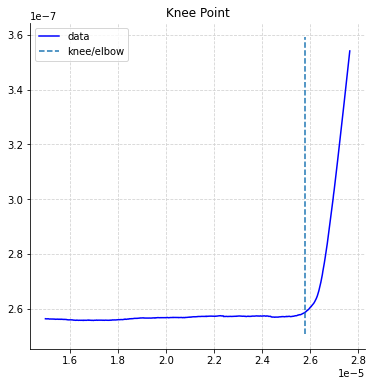

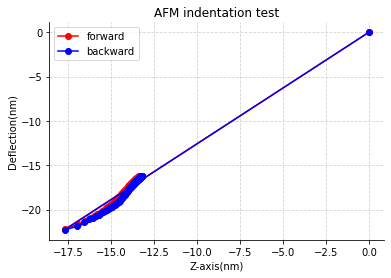

1.6494855429044908 5.710264198250165 1.2567107067213892 -0.0494720175141289


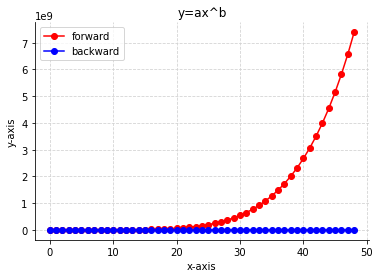

In [40]:
# Hertzian Curve Fitting
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator, DataGenerator as dg

zf = data["z-axis sensor_spec forward"].reshape(-1)
df = data["deflection_spec forward"].reshape(-1)
zb = data["z-axis sensor_spec backward"].reshape(-1)
db = data["deflection_spec backward"].reshape(-1)

# Change the Z-axis sensor -> Z-axis sensor - Raw deflection / Broadcating
zf = zf - df
zb = zb - db

# Find the kneepoint 
xf, yf = zf, df
xb, yb = zb, db
klf = KneeLocator(xf,yf, curve="convex")
klb = KneeLocator(xb,yb, curve="convex")
klf.plot_knee()
klb.plot_knee()
kpf = klf.knee
kpb = klb.knee

# Move to origin
num_zf = len(zf)
num_zb = len(zb)

zf = np.delete(zf, np.where(zf<kpf))
zb = np.delete(zb, np.where(zb<kpb))
df = np.delete(df, np.where(df<df[num_zf-len(zf)]))
db = np.delete(db, np.where(db<db[num_zb-len(zb)]))

lf = len(zf)
lb = len(zb)

for i in range(1,lf):
    zf[i] = np.log(zf[i] - zf[0])
    df[i] = np.log(df[i] - df[0])

for i in range(1,lb):
    zb[i] = np.log(zb[i] - zb[0])
    db[i] = np.log(db[i] - db[0])

fig, ax = plt.subplots(1, 1)   

ax.plot(zf, df, "o-", color = "red", label = 'forward')
ax.plot(zb, db, "o-", color = "blue", label = 'backward')
ax.set_xlabel('Z-axis(nm)')
ax.set_ylabel('Deflection(nm)')
ax.set_title('AFM indentation test')
ax.grid(ls = "--", color = "lightgray")
ax.legend()

plt.show()

# least square fitting
a11 = 0
a12 = 0
b1 = 0
b2 = 0

for i in range(1,lf):
    a11 += zf[i]*zf[i]
    a12 += zf[i]
    b1 += zf[i]*df[i]
    b2 += df[i]

a21 = a12
a22 = lf -1

af = (a22*b1-a12*b2)/(a11*a22-a12*a21)
bf = (a11*b2-a21*b1)/(a11*a22-a12*a21)

for i in range(1,lb):
    a11 += zb[i]*zb[i]
    a12 += zb[i]
    b1 += zb[i]*db[i]
    b2 += db[i]
a21 = a12
a22 = lb -1

ab = (a22*b1-a12*b2)/(a11*a22-a12*a21)
bb = (a11*b2-a21*b1)/(a11*a22-a12*a21)

print(af, bf, ab, bb)

x = range(1,50)
yf = af*pow(x,bf)
yb = ab*pow(x,bb)

fig, ax = plt.subplots(1, 1)   

ax.plot(yf, "o-", color = "red", label = 'forward')
ax.plot(yb, "o-", color = "blue", label = 'backward')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_title('y=ax^b')
ax.grid(ls = "--", color = "lightgray")
ax.legend()

plt.show()

In [ ]:
# Hertzian Curve Fitting(modified)
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator, DataGenerator as dg

zf = data["z-axis sensor_spec forward"].reshape(-1)
df = data["deflection_spec forward"].reshape(-1)
zb = data["z-axis sensor_spec backward"].reshape(-1)
db = data["deflection_spec backward"].reshape(-1)

z_dict = {"f": zf, "b": zb}
d_dict = {"f": df, "b": db}

# Change the Z-axis sensor -> Z-axis sensor - Raw deflection / Broadcating
def z_sensor_to_tip_position(z_sensor: np.ndarray, deflection: np.ndarray)-> np.ndarray:
    if len(z_sensor) == len(deflection):
        z_sensor = z_sensor - deflection
    return z_sensor
    
z_dict = {k : z_sensor_to_tip_position(z_dict[k], d_dict[k]) for k in ("f", "b")}

# Find the kneepoint 
def find_kneepoint(z_sensor: np.ndarray, deflection: np.ndarray):
    kl = KneeLocator(z_sensor, deflection, curve="convex")
    kl.plot_knee()
    num = len(z_sensor)
    z_sensor = np.delete(z_sensor, np.where(z_sensor<kl.knee))
    deflection = np.delete(deflection, np.where(deflection<[deflection[num-len(z_sensor)]]))
    return [z_sensor, deflection]

a = {}
b = {}
for i in ("f", "b"):
    a = {i : find_kneepoint(z_dict[i],d_dict[i])}
    b.update(a)

z_dict = {k: b[k][0] for k in ("f", "b")}
d_dict = {k: b[k][1] for k in ("f", "b")}

# Move to origin
def move_to_origin(z_sensor:np.ndarray, deflection:np.ndarray):
    ln = len(z_sensor)
    for i in range(1,ln):
        z_sensor[i] = np.log(z_sensor[i] - z_sensor[0])
        deflection[i] = np.log(deflection[i] - deflection[0])
    return [z_sensor, deflection]

z_dict = {k : move_to_origin(z_dict[k],d_dict[k])[0] for k in ("f","b")}
d_dict = {k : move_to_origin(z_dict[k],d_dict[k])[1] for k in ("f","b")}

directions = ["f", "b"]
names = ["forward", "backward"]
colors = ["red", "blue"]

fig, ax = plt.subplots(1, 1)   

for d, n, c in zip(directions, names, colors):
    ax.plot(z_dict[d], d_dict[d], "o-", color = c, label = n)
    ax.set_xlabel('Z-axis(nm)')
    ax.set_ylabel('Deflection(nm)')
    ax.set_title('AFM indentation test')
    ax.grid(ls = "--", color = "lightgray")
    ax.legend()
    plt.show()

# least square fitting
def linear_fitting(z_sensor, deflection) :
    a11 = 0
    a12 = 0
    b1 = 0
    b2 = 0
    len = len(z_sensor)
    for i in range(1,len):
        a11 += zf[i]*zf[i]
        a12 += zf[i]
        b1 += zf[i]*df[i]
        b2 += df[i]

    a21 = a12
    a22 = len -1
    a = (a22*b1-a12*b2)/(a11*a22-a12*a21)
    b = (a11*b2-a21*b1)/(a11*a22-a12*a21)
    return a, b

x = range(1,50)
yf = af*pow(x,bf)
yb = ab*pow(x,bb)

fig, ax = plt.subplots(1, 1)   

ax.plot(yf, "o-", color = "red", label = 'forward')
ax.plot(yb, "o-", color = "blue", label = 'backward')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_title('y=ax^b')
ax.grid(ls = "--", color = "lightgray")
ax.legend()

plt.show()